# SEPP

This is the full-blown, self-excited point process model with non-parametric kernels.

In [1]:
%matplotlib inline
from common import *
datadir = os.path.join("//media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")

GDAL_DATA not set and failed to find suitable location...  This is probably not a problem on linux.


In [2]:
import open_cp.sepp as sepp
import open_cp.predictors

import open_cp.logger
open_cp.logger.log_to_true_stdout()

In [2]:
south_side, points = load_data(datadir)
points.time_range

(numpy.datetime64('2011-03-01T00:01:00.000'),
 numpy.datetime64('2012-01-06T19:00:00.000'))

In [3]:
masked_grid = grid_for_south_side()

## Train

Here we experiment with using the `StocasticDecluster` class directly, to tune parameters.  I also ran the convergence algorithm without "bandwidths".  This is very (very!) slow, but checks that our bandwidths are appropriate.

In [8]:
flipped = open_cp.data.TimedPoints.from_coords(points.timestamps, points.ycoords, points.xcoords)
region = masked_grid.region()
flipped_region = open_cp.data.RectangularRegion(xmin=region.ymin, xmax=region.ymax,
                                                ymin=region.xmin, ymax=region.xmax)

In [9]:
trainer = sepp.SEPPTrainer()
trainer.data = points

In [10]:
sd = trainer.make_stocastic_decluster()
sd.initial_time_bandwidth = 10000
p = sd.initial_p_matrix()
backgrounds, aftershocks = sepp.sample_points(sd.points, p)

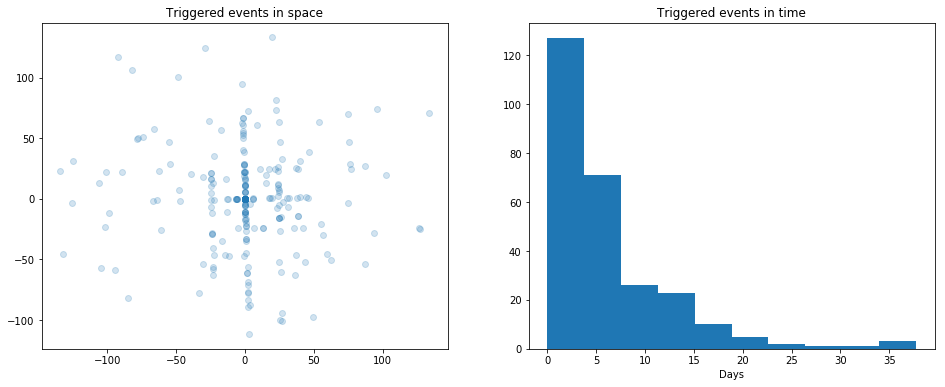

In [11]:
def plot_space_time(aftershocks):
    fig, ax = plt.subplots(ncols=2, figsize=(16,6))

    ax[0].scatter(aftershocks[1], aftershocks[2], alpha=.2)
    ax[0].set_title("Triggered events in space")

    ax[1].hist(aftershocks[0] / 60 / 24)
    ax[1].set_title("Triggered events in time")
    ax[1].set_xlabel("Days")
    None
    
plot_space_time(aftershocks)

In [12]:
result = sd.run_optimisation(40)

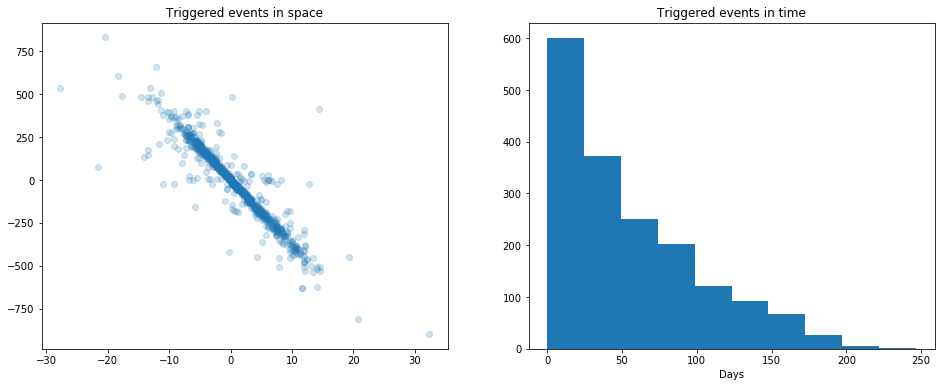

In [13]:
backgrounds, aftershocks = sepp.sample_points(sd.points, result.p)
plot_space_time(aftershocks)

### Conclusions

- Changing the "initial bandwidths" leads to a different initial estimate.
- But the final estimate we converge to seems unchanged.
- By removing the convergence bandwidth cutoffs, we obtain a "trigger kernel" which has a much long time tail than expected (up to 200 days).
- But the overall pattern, and spatial distribution, looks the same.

Which is frustrating, as it suggests converging to this very "North-South" dominated distribution seems stable.

# Back to the usual procedure

Let us now return to using the main library code, even though we know that the "bandwidths" set are not entirely correct.

In [5]:
trainer = sepp.SEPPTrainer()
trainer.data = points
predictor = trainer.train(iterations=40)

In [15]:
def plot_density(predictor, ax, region):
    kernel_array = open_cp.predictors.grid_prediction_from_kernel(predictor.background_kernel.space_kernel,
        region, masked_grid.xsize)
    ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
    mesh = ax.pcolormesh(*kernel_array.mesh_data(), kernel_array.intensity_matrix * 10000, cmap="Blues")
    fig.colorbar(mesh, ax=ax)
    return kernel_array

# Time unit is minutes
def plot_time(points, kernel):
    total_time = points.time_deltas()[-1]
    tc = np.linspace(-total_time * 0.1, total_time * 1.1, 100)
    def actual(t):
        return ((t>=0) & (t<=total_time)) / total_time
    days_tc = tc / 60 / 24
    ax[1].plot(days_tc, actual(tc) * 10000, linewidth=1, color="r")
    ax[1].scatter(days_tc, kernel.time_kernel(tc) * 10000)
    ax[0].set_title("Estimated background risk in space")
    ax[1].set_title("Estimated background risk in time")
    ax[1].set_xlabel("Days from start")

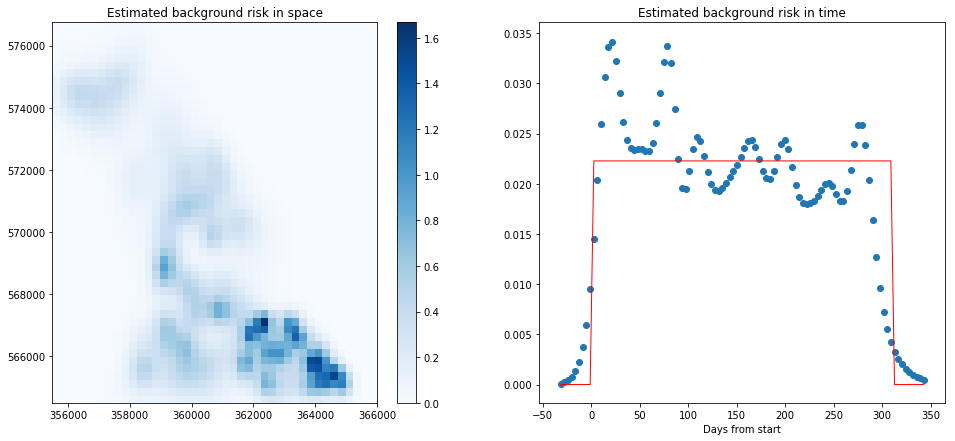

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
kernel_array = plot_density(predictor, ax[0], masked_grid.region())
plot_time(points, predictor.background_kernel)

## Stocastically decluster

Using the computed kernels, we take a sample of which points are estimated to be "background" and what the triggering events look like.

The most obvious problem is that the "triggered" events are aligned almost vertically North/South.  We would expect a much more homogeneous pattern; or at least also a strong east/west bias, reflecting the grid layout of Chicago.

In [7]:
backgrounds, aftershocks, triggers = sepp.sample_offsets(trainer.as_time_space_points(), predictor.result.p)

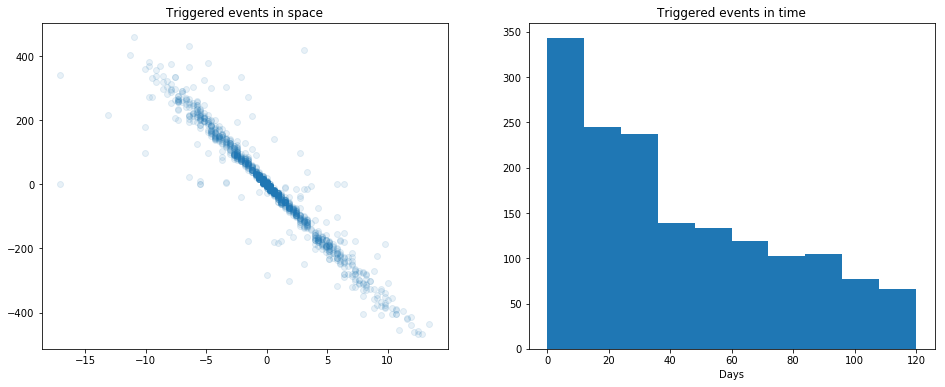

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(aftershocks[1], aftershocks[2], alpha=0.1)
ax[0].set_title("Triggered events in space")

ax[1].hist(aftershocks[0] / 60 / 24)
ax[1].set_title("Triggered events in time")
ax[1].set_xlabel("Days")
None

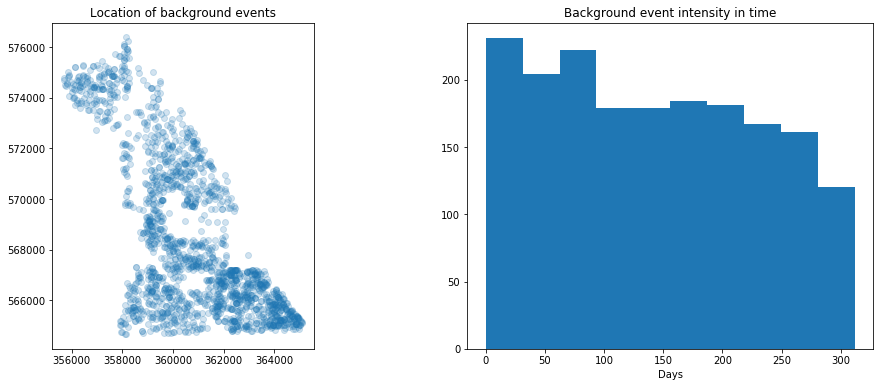

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(backgrounds[1], backgrounds[2], alpha=0.2)
ax[0].set_title("Location of background events")
ax[0].set_aspect(1)

ax[1].hist(backgrounds[0] / 60 / 24)
ax[1].set_title("Background event intensity in time")
ax[1].set_xlabel("Days")
None

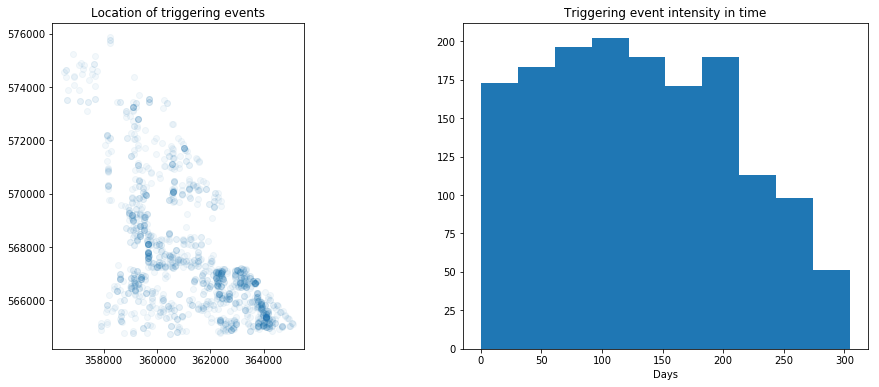

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(triggers[1], triggers[2], alpha=0.05)
ax[0].set_title("Location of triggering events")
ax[0].set_aspect(1)

ax[1].hist(triggers[0] / 60 / 24)
ax[1].set_title("Triggering event intensity in time")
ax[1].set_xlabel("Days")
None

## Conclusion

Immediately above we have plotted the location of "trigger" events-- those events which (under our stocastic estimate) directly give rise to other events.
- Notice that these are strongly clustered in the South East corner of the region.
- (We have plotted this with a much smaller `alpha` parameter than for the backgrounds).
- This, perhaps, shows a flaw in the algorithm.  While the background intensity and triggering intensity are estimated in a non-parametric way, the model assumes that the triggering kernel is the same for all time and space.
- So, again conjecturally, what could be happening is that the South East corner of the data is dominating, and in this region it is appropriate that the triggering kernel is North/South dominated.  As the kernel cannot vary, we are forced into this even though it may be inappropriate for other regions of the data set.

# Try North side

In [3]:
north_side, points = load_data(datadir, side="North")
points.time_range

(numpy.datetime64('2011-03-01T06:30:00.000'),
 numpy.datetime64('2012-01-06T21:00:00.000'))

In [4]:
masked_grid = grid_for_side(side="North")

In [12]:
import importlib
importlib.reload(open_cp.kernels)

<module 'open_cp.kernels' from '/nfs/see-fs-02_users/matmdpd/Crime Predict Project/PredictCode/open_cp/kernels.py'>

In [13]:
trainer = sepp.SEPPTrainer()
trainer.data = points
predictor = trainer.train(iterations=40)

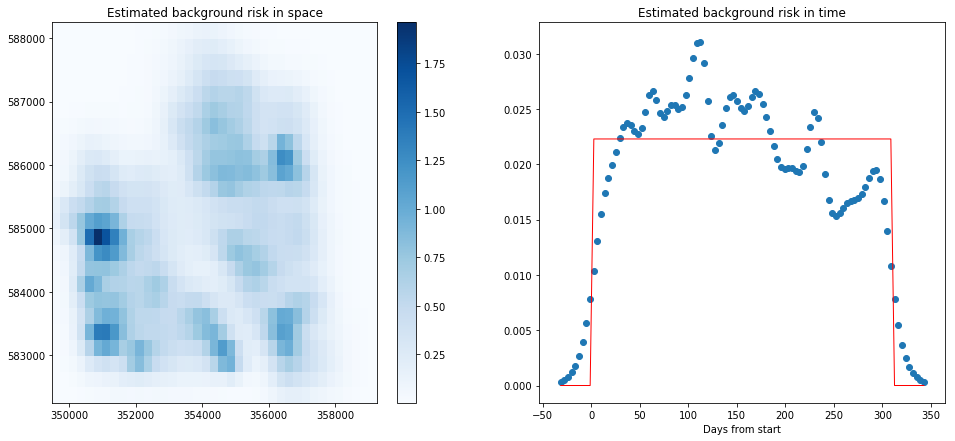

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
kernel_array = plot_density(predictor, ax[0], masked_grid.region())
plot_time(points, predictor.background_kernel)

In [17]:
backgrounds, aftershocks, triggers = sepp.sample_offsets(trainer.as_time_space_points(), predictor.result.p)

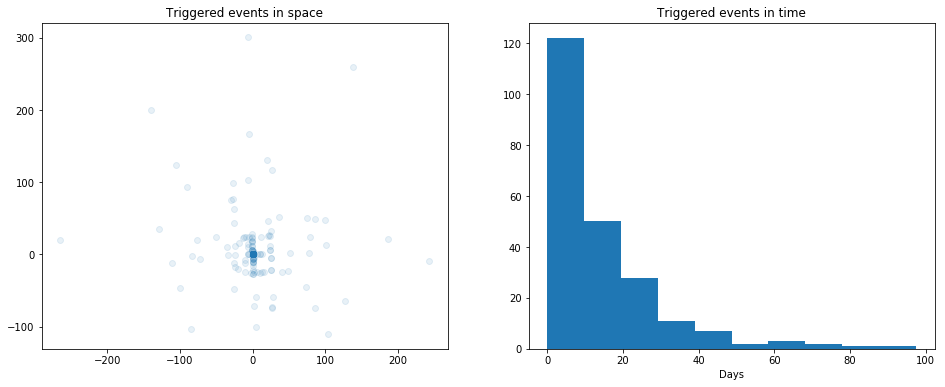

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(aftershocks[1], aftershocks[2], alpha=0.1)
ax[0].set_title("Triggered events in space")

ax[1].hist(aftershocks[0] / 60 / 24)
ax[1].set_title("Triggered events in time")
ax[1].set_xlabel("Days")
None

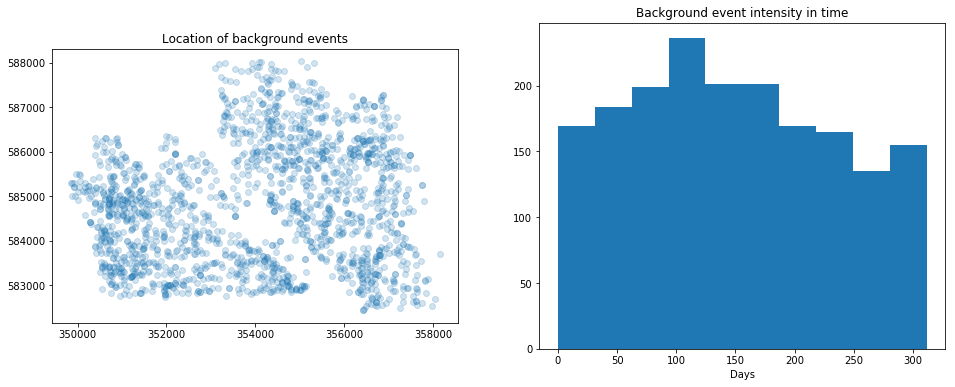

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(backgrounds[1], backgrounds[2], alpha=0.2)
ax[0].set_title("Location of background events")
ax[0].set_aspect(1)

ax[1].hist(backgrounds[0] / 60 / 24)
ax[1].set_title("Background event intensity in time")
ax[1].set_xlabel("Days")
None

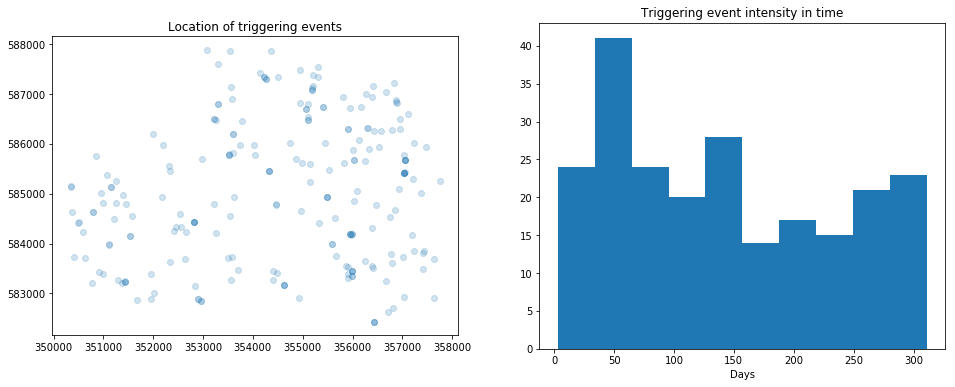

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(triggers[1], triggers[2], alpha=0.2)
ax[0].set_title("Location of triggering events")
ax[0].set_aspect(1)

ax[1].hist(triggers[0] / 60 / 24)
ax[1].set_title("Triggering event intensity in time")
ax[1].set_xlabel("Days")
None